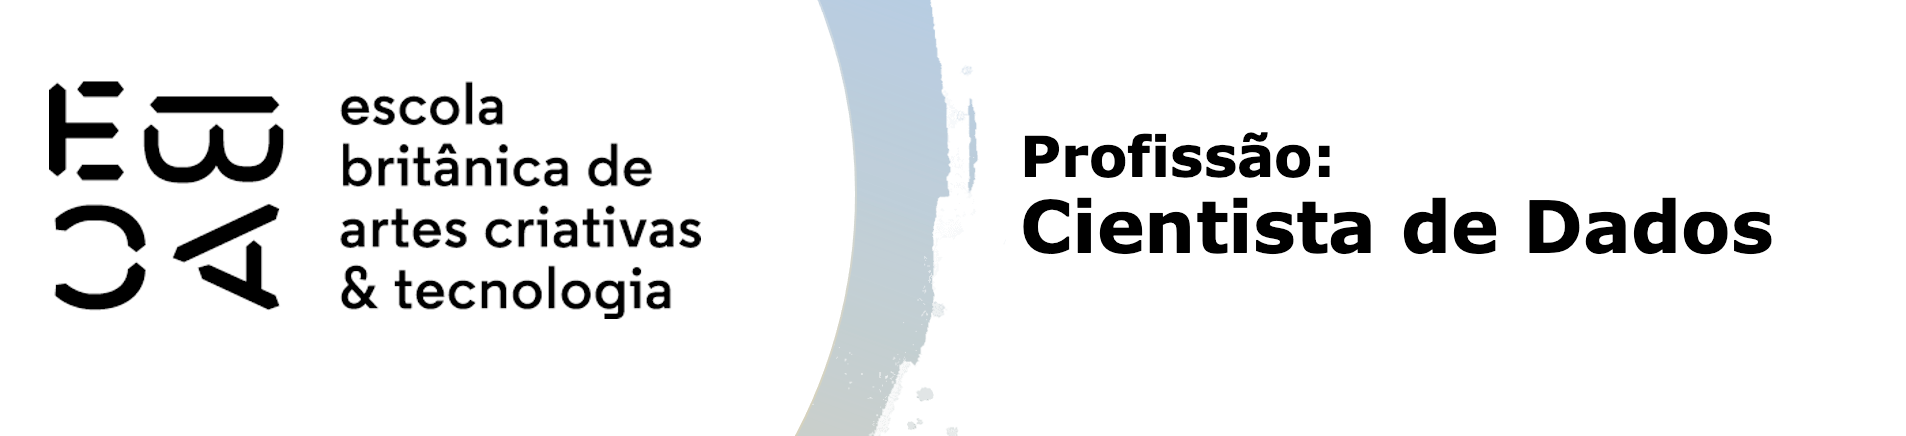

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from pycaret.classification import *
from scipy import stats

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
# Carregar a base de dados
df = pd.read_feather('credit_scoring.ftr')

# Excluir 'index' que não deve ser utilizado como covariável
df.drop('index', axis=1, inplace=True)

# Identificar os três últimos meses na variável data_ref
ultimos_tres_meses = df['data_ref'].sort_values().unique()[-3:]
print("Três últimos meses para validação out of time:")
print(ultimos_tres_meses)

# Filtrar dados de treino e validação
dados_treino = df[~df['data_ref'].isin(ultimos_tres_meses)]
dados_validacao = df[df['data_ref'].isin(ultimos_tres_meses)]

# Separar variáveis explicativas (X) e variável alvo (y)
X_treino = dados_treino.drop(['data_ref', 'mau'], axis=1)  # Excluir 'data_ref' que não é variável explicativa
y_treino = dados_treino['mau']

X_validacao = dados_validacao.drop(['data_ref', 'mau'], axis=1)  # Excluir 'data_ref' que não é variável explicativa
y_validacao = dados_validacao['mau']

# Verificar o tamanho dos conjuntos
print("\nTamanho do conjunto de treino:", len(X_treino))
print("Tamanho do conjunto de validação:", len(X_validacao))


Três últimos meses para validação out of time:
<DatetimeArray>
['2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 3, dtype: datetime64[ns]

Tamanho do conjunto de treino: 600000
Tamanho do conjunto de validação: 150000


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
# Verificar o número total de linhas
num_linhas_total = len(df)
print(f"Número total de linhas: {num_linhas_total}")

# Contagem de linhas para cada mês em data_ref
contagem_por_mes = df['data_ref'].value_counts().sort_index()
print("\nContagem de linhas por mês em data_ref:")
print(contagem_por_mes)


Número total de linhas: 750000

Contagem de linhas por mês em data_ref:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


In [5]:
# Listar variáveis qualitativas
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 
                          'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

# Contagem de categorias para cada variável qualitativa
for var in variaveis_qualitativas:
    print(f"\nContagem de categorias para {var}:")
    print(df[var].value_counts())



Contagem de categorias para sexo:
sexo
F    504580
M    245420
Name: count, dtype: int64

Contagem de categorias para posse_de_veiculo:
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

Contagem de categorias para posse_de_imovel:
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

Contagem de categorias para tipo_renda:
tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64

Contagem de categorias para educacao:
educacao
Médio                  506836
Superior completo      204306
Superior incompleto     29471
Fundamental              8575
Pós graduação             812
Name: count, dtype: int64

Contagem de categorias para estado_civil:
estado_civil
Casado      526472
Solteiro     91659
União        57685
Separado     42571
Viúvo        31613
Name: count, dtype: int64

Contagem de categorias para tipo_residencia:
tipo_residencia
Casa    

In [6]:
# Listar variáveis quantitativas
variaveis_quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 
                           'qt_pessoas_residencia', 'renda']

# Estatísticas descritivas para cada variável quantitativa
descritivo_quantitativas = df[variaveis_quantitativas].describe()
print("\nEstatísticas descritivas para variáveis quantitativas:")
print(descritivo_quantitativas)



Estatísticas descritivas para variáveis quantitativas:
          qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
count  750000.000000  750000.000000  624043.000000          750000.000000   
mean        0.433251      43.804733       7.748574               2.212241   
std         0.739379      11.229868       6.687455               0.903428   
min         0.000000      22.000000       0.117808               1.000000   
25%         0.000000      34.000000       3.049315               2.000000   
50%         0.000000      43.000000       6.046575               2.000000   
75%         1.000000      53.000000      10.183562               3.000000   
max        14.000000      68.000000      42.906849              15.000000   

              renda  
count  7.500000e+05  
mean   2.323854e+04  
std    7.910601e+04  
min    1.076700e+02  
25%    3.467700e+03  
50%    7.861820e+03  
75%    1.831828e+04  
max    4.083986e+06  


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

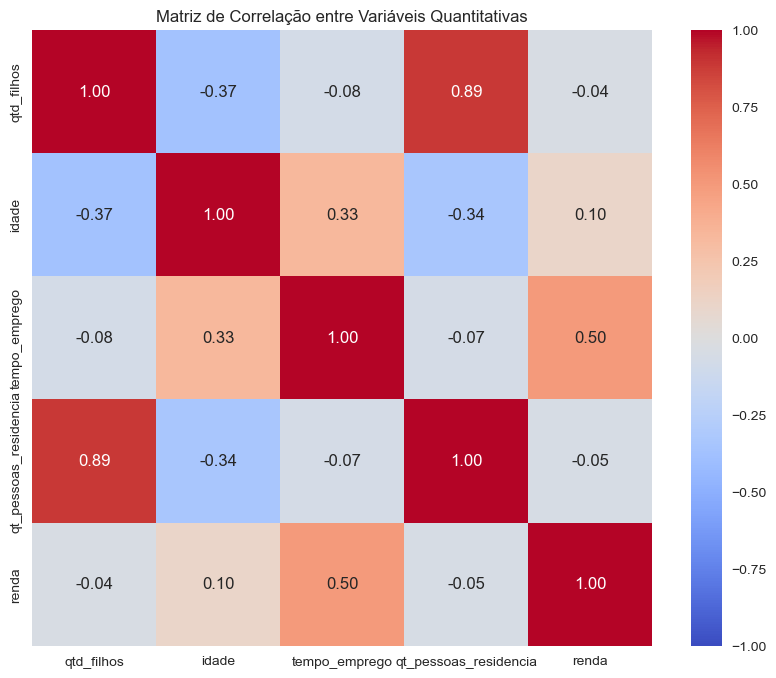

Matriz de Correlação entre Variáveis Quantitativas:
                       qtd_filhos     idade  tempo_emprego  \
qtd_filhos               1.000000 -0.370234      -0.075299   
idade                   -0.370234  1.000000       0.330063   
tempo_emprego           -0.075299  0.330063       1.000000   
qt_pessoas_residencia    0.890352 -0.341151      -0.066361   
renda                   -0.041886  0.101772       0.496360   

                       qt_pessoas_residencia     renda  
qtd_filhos                          0.890352 -0.041886  
idade                              -0.341151  0.101772  
tempo_emprego                      -0.066361  0.496360  
qt_pessoas_residencia               1.000000 -0.047790  
renda                              -0.047790  1.000000  


In [7]:
# Selecionar variáveis quantitativas
variaveis_quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Calcular matriz de correlação
correlacao_quantitativas = df[variaveis_quantitativas].corr()

# Plotar mapa de calor da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao_quantitativas, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlação entre Variáveis Quantitativas')
plt.show()

# Exibir matriz de correlação
print("Matriz de Correlação entre Variáveis Quantitativas:")
print(correlacao_quantitativas)

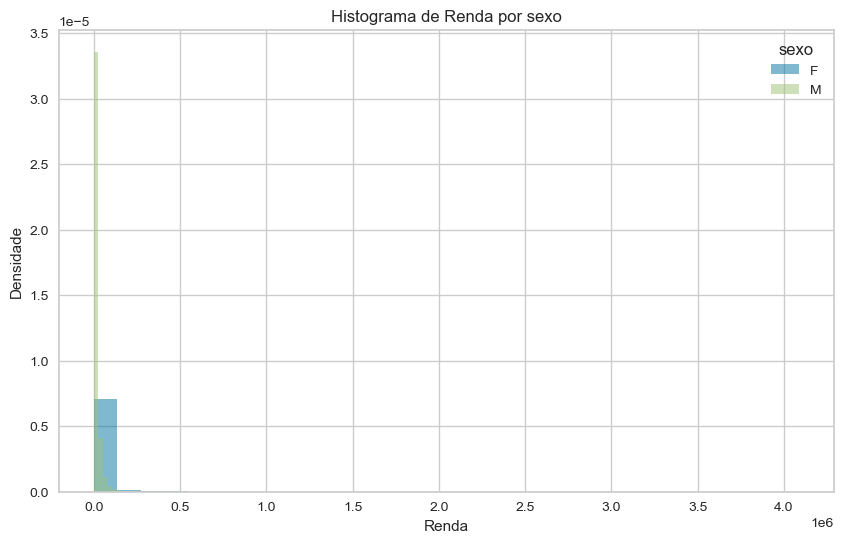

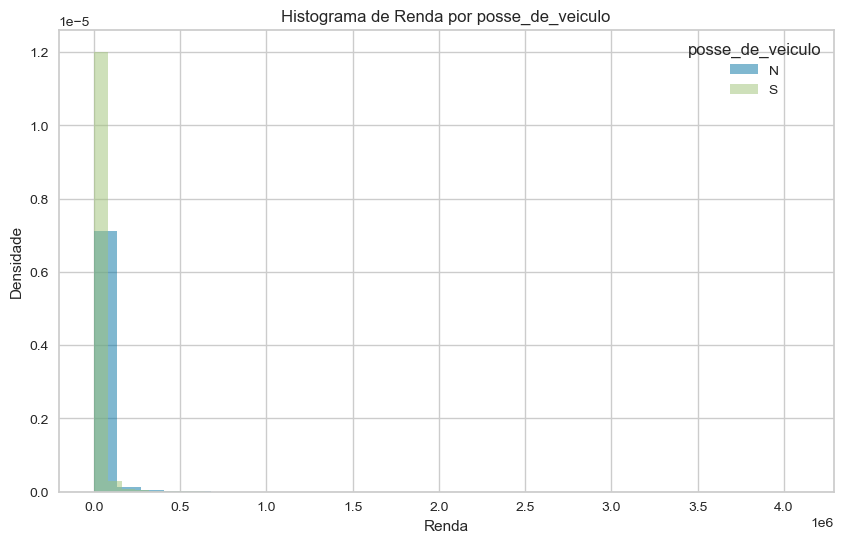

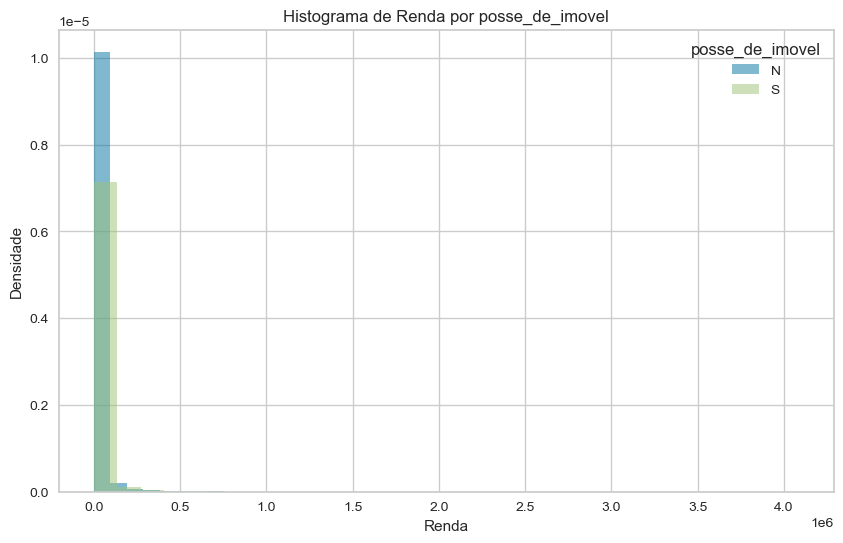

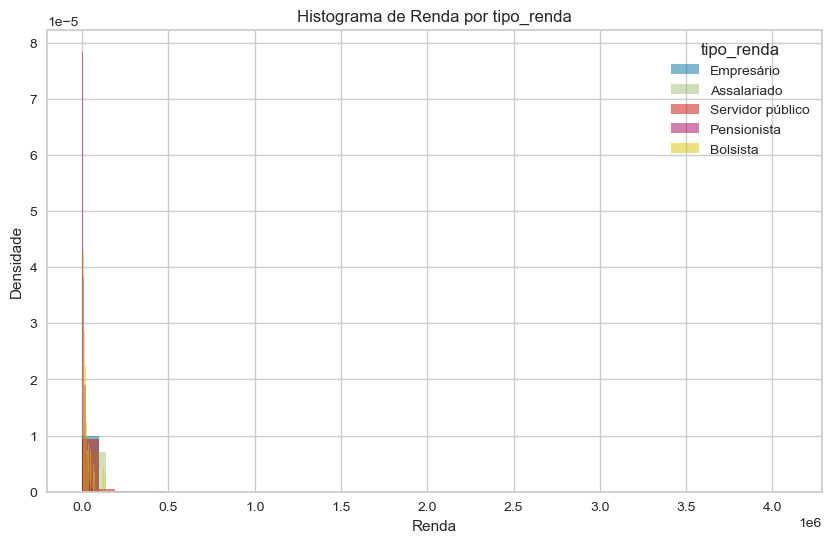

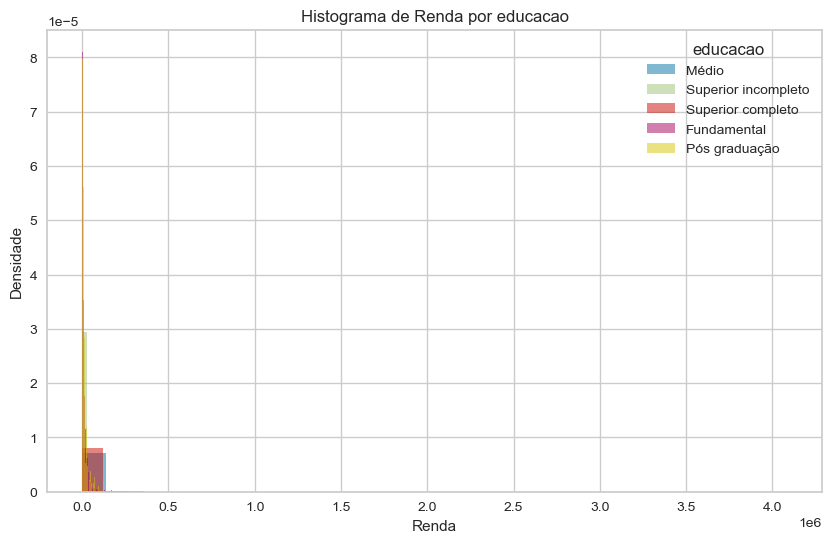

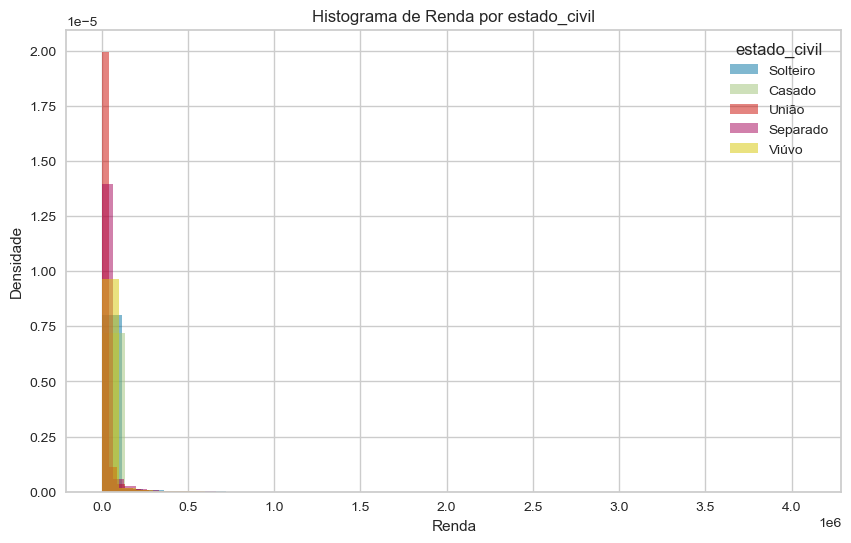

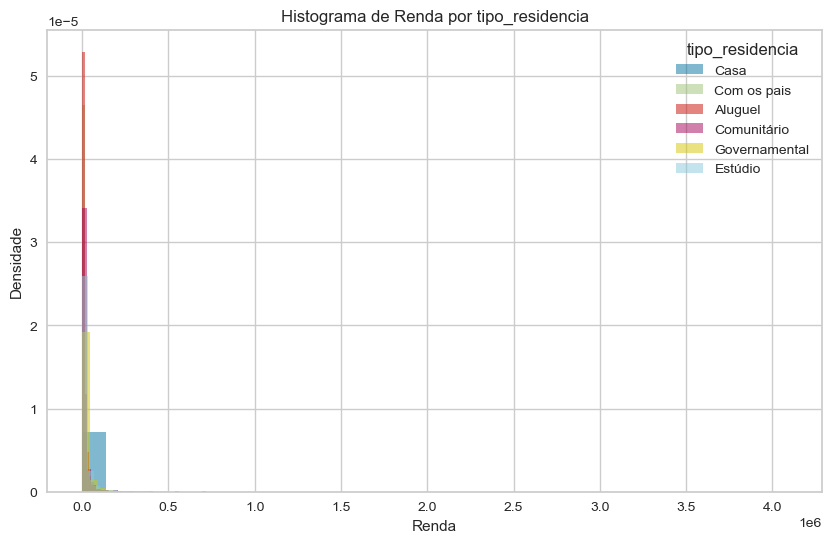

In [8]:
# Plotar histogramas para variáveis qualitativas em relação à renda
for var_qualitativa in df.select_dtypes(include=['object']).columns:
    if var_qualitativa != 'data_ref' and var_qualitativa != 'mau':  # Excluir 'data_ref' que não é variável explicativa
        plt.figure(figsize=(10, 6))
        for categoria in df[var_qualitativa].unique():
            subset = df[df[var_qualitativa] == categoria]
            plt.hist(subset['renda'], bins=30, alpha=0.5, label=categoria, density=True)
        plt.title(f'Histograma de Renda por {var_qualitativa}')
        plt.xlabel('Renda')
        plt.ylabel('Densidade')
        plt.legend(title=var_qualitativa)
        plt.show()


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [9]:
# Identificar valores ausentes
valores_ausentes = df.isnull().sum()

print("Valores ausentes por coluna:")
print(valores_ausentes)


Valores ausentes por coluna:
data_ref                      0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64


Estatísticas descritivas:
                  data_ref     qtd_filhos          idade  tempo_emprego  \
count               750000  750000.000000  750000.000000  624043.000000   
mean   2015-08-01 06:24:00       0.433251      43.804733       7.748574   
min    2015-01-01 00:00:00       0.000000      22.000000       0.117808   
25%    2015-04-01 00:00:00       0.000000      34.000000       3.049315   
50%    2015-08-01 00:00:00       0.000000      43.000000       6.046575   
75%    2015-12-01 00:00:00       1.000000      53.000000      10.183562   
max    2016-03-01 00:00:00      14.000000      68.000000      42.906849   
std                    NaN       0.739379      11.229868       6.687455   

       qt_pessoas_residencia         renda  
count          750000.000000  7.500000e+05  
mean                2.212241  2.323854e+04  
min                 1.000000  1.076700e+02  
25%                 2.000000  3.467700e+03  
50%                 2.000000  7.861820e+03  
75%                 3.000000

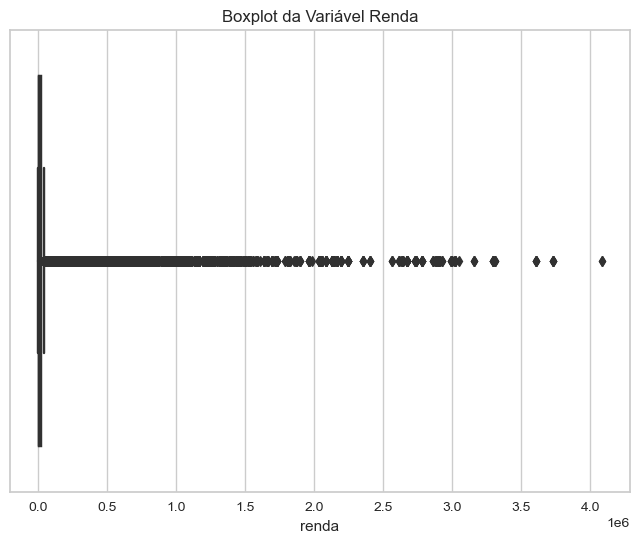

In [10]:
# Estatísticas descritivas
estatisticas_descritivas = df.describe()

print("Estatísticas descritivas:")
print(estatisticas_descritivas)

# Visualizar outliers usando boxplot (por exemplo, na variável 'renda')
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['renda'])
plt.title('Boxplot da Variável Renda')
plt.show()


In [11]:
# Contagem de zeros em uma variável específica (por exemplo, 'tempo_emprego')
contagem_zeros = (df['tempo_emprego'] == 0).sum()

print("Número de zeros na variável 'tempo_emprego':", contagem_zeros)


Número de zeros na variável 'tempo_emprego': 0


### Tratamentos:

In [12]:
# Remover linhas com valores ausentes na coluna tempo_emprego
df = df.dropna(subset=['tempo_emprego'])

# Verificar se ainda há valores ausentes
print("Valores ausentes após remoção na variável 'tempo_emprego':", df['tempo_emprego'].isnull().sum())


Valores ausentes após remoção na variável 'tempo_emprego': 0


In [13]:
# Substituir zeros por -1 em tempo_emprego
df['tempo_emprego'] = df['tempo_emprego'].replace(0, -1)

# Verificar se existem zeros na variável 'tempo_emprego' após tratamento
print("Número de zeros na variável 'tempo_emprego' após tratamento:", (df['tempo_emprego'] == 0).sum())




Número de zeros na variável 'tempo_emprego' após tratamento: 0


In [14]:
# Visualizar a coluna tempo_emprego
print(df['tempo_emprego'])


0          6.873973
1          4.526027
2          0.243836
3         12.772603
4          8.432877
            ...    
749993    13.298630
749995     3.038356
749997    10.375342
749998    13.780822
749999    10.375342
Name: tempo_emprego, Length: 624043, dtype: float64


Estatísticas Descritivas da Variável tempo_emprego:
count    624043.000000
mean          7.748574
std           6.687455
min           0.117808
25%           3.049315
50%           6.046575
75%          10.183562
max          42.906849
Name: tempo_emprego, dtype: float64


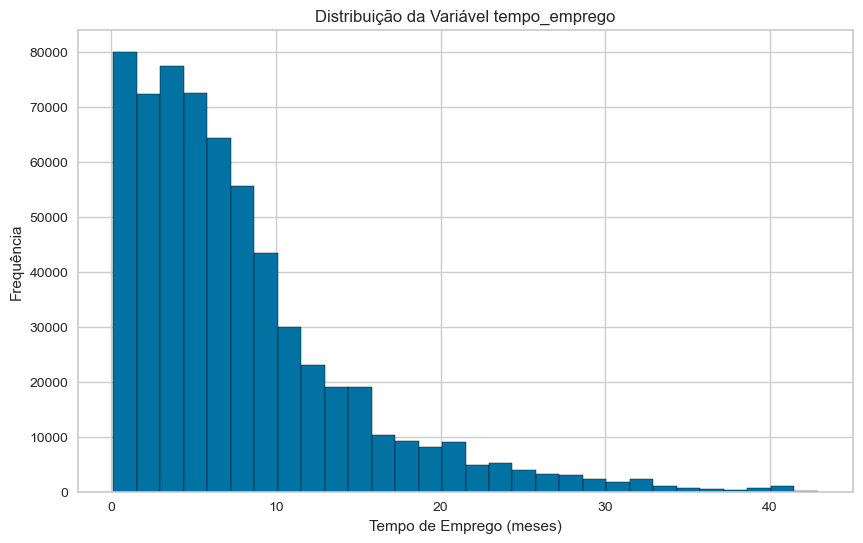

In [15]:
# Calcular estatísticas descritivas da variável tempo_emprego
desc_stats = df['tempo_emprego'].describe()

# Imprimir as estatísticas descritivas
print("Estatísticas Descritivas da Variável tempo_emprego:")
print(desc_stats)

# Plotar histograma da variável tempo_emprego
plt.figure(figsize=(10, 6))
plt.hist(df['tempo_emprego'], bins=30, edgecolor='black')
plt.title('Distribuição da Variável tempo_emprego')
plt.xlabel('Tempo de Emprego (meses)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


In [16]:
# Calcular estatísticas descritivas para identificar outliers
estatisticas = df.describe()

# Definir critérios para identificar outliers (por exemplo, usando o método do IQR)
Q1 = estatisticas['tempo_emprego']['25%']
Q3 = estatisticas['tempo_emprego']['75%']
IQR = Q3 - Q1

# Definir limites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar dados para remover outliers usando sample()
df_filtrado = df[(df['tempo_emprego'] >= limite_inferior) & (df['tempo_emprego'] <= limite_superior)].sample(frac=1.0)

# Comparar tamanhos antes e depois da remoção de outliers
print("Tamanho do DataFrame original:", len(df))
print("Tamanho do DataFrame após remoção de outliers:", len(df_filtrado))


Tamanho do DataFrame original: 624043
Tamanho do DataFrame após remoção de outliers: 589482


### Agrupamento

In [17]:
# Agrupamento da variável sexo
df['sexo'] = df['sexo'].apply(lambda x: 'Outros' if x not in ['F', 'M'] else x)

# Agrupar categorias menos frequentes em 'Outros'
df['tipo_renda'] = df['tipo_renda'].apply(lambda x: 'Outros' if x not in ['Assalariado', 'Empresário', 'Pensionista', 'Servidor público'] else x)

# Agrupamento da variável educacao
# Agrupar níveis de educação semelhantes
df['educacao'] = df['educacao'].apply(lambda x: 'Superior' if x in ['Superior completo', 'Superior incompleto'] else x)

# Visualizar contagem de cada categoria após agrupamento
print(df['sexo'].value_counts())
print(df['tipo_renda'].value_counts())
print(df['educacao'].value_counts())


sexo
F    396774
M    227269
Name: count, dtype: int64
tipo_renda
Assalariado         385740
Empresário          172712
Servidor público     64922
Outros                 361
Pensionista            308
Name: count, dtype: int64
educacao
Médio            406901
Superior         211422
Fundamental        4908
Pós graduação       812
Name: count, dtype: int64


### Modelo

In [18]:
# Selecionar variáveis explicativas (features)
X = df[['sexo', 'tipo_renda', 'educacao', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']]
y = df['mau']

# Converter variáveis categóricas em variáveis dummy (ou usar OneHotEncoder)
X = pd.get_dummies(X, drop_first=True)

# Dividir dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizar variáveis numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializar e ajustar o modelo de regressão logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Avaliar o modelo
train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)

print(f'Acurácia no conjunto de treino: {train_score:.4f}')
print(f'Acurácia no conjunto de teste: {test_score:.4f}')

# Coeficientes do modelo
coefficients = pd.DataFrame(model.coef_.flatten(), index=X.columns, columns=['Coefficient'])
print('\nCoeficientes do modelo:')
print(coefficients)


Acurácia no conjunto de treino: 0.9226
Acurácia no conjunto de teste: 0.9232

Coeficientes do modelo:
                             Coefficient
idade                          -0.015540
tempo_emprego                  -0.182488
qt_pessoas_residencia          -0.000801
renda                         -10.516877
sexo_M                         -0.055882
tipo_renda_Empresário          -0.017678
tipo_renda_Outros              -0.001224
tipo_renda_Pensionista          0.004411
tipo_renda_Servidor público    -0.007427
educacao_Médio                 -0.028602
educacao_Pós graduação         -0.008663
educacao_Superior              -0.052934


### Ajustar os hiperparâmetros

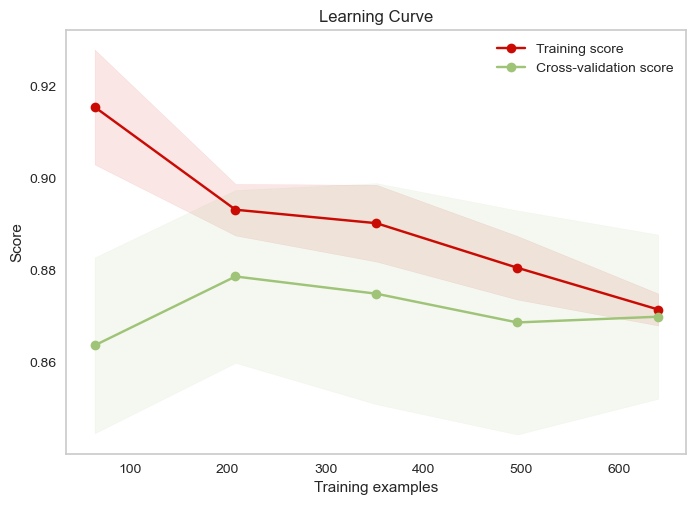

Acurácia no conjunto de treino: 0.8700
Acurácia no conjunto de teste: 0.8300
Coeficientes do modelo:
    Coefficient
1     -0.452191
2      0.161201
3     -0.745104
4      0.055516
5     -0.043181
6     -0.228760
7      1.620411
8     -0.003264
9     -0.629024
10     0.102537


In [19]:
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Divisão dos dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de Regressão Logística
logistic_regression_model = LogisticRegression()

# Treinamento do modelo
logistic_regression_model.fit(X_train, y_train)

# Função para plotar a curva de aprendizado
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plotar a curva de aprendizado
plot_learning_curve(logistic_regression_model, "Learning Curve", X_train, y_train, cv=5)
plt.show()

# Calcular e exibir métricas de treino e teste
train_predictions = logistic_regression_model.predict(X_train)
test_predictions = logistic_regression_model.predict(X_test)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Acurácia no conjunto de treino: {train_accuracy:.4f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")

# Coeficientes do modelo
coeficientes = pd.DataFrame(logistic_regression_model.coef_.T, columns=['Coefficient'], index=np.arange(1, X.shape[1] + 1))
print("Coeficientes do modelo:")
print(coeficientes)


In [20]:
# Definindo os parâmetros a serem testados
param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Criando o modelo de regressão logística
log_reg = LogisticRegression(max_iter=1000)

# Grid Search com cross-validation
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Melhor score
print("Melhor score:", grid_search.best_score_)

# Avaliando o modelo no conjunto de teste com os melhores parâmetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste com os melhores parâmetros: {test_accuracy:.4f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Melhores parâmetros encontrados:
{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Melhor score: 0.8787500000000001
Acurácia no conjunto de teste com os melhores parâmetros: 0.8250


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [21]:
# Padronizar variáveis numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializar e ajustar o modelo de regressão logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Previsões e escores no conjunto de treino e teste
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_train_score = model.predict_proba(X_train_scaled)[:, 1]
y_test_score = model.predict_proba(X_test_scaled)[:, 1]

# Função para calcular KS e Gini
def calculate_ks_gini(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    gini = 2 * roc_auc - 1
    ks = max(tpr - fpr)
    return ks, gini

# Função para avaliar métricas
def evaluate_model(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    ks, gini = calculate_ks_gini(y_true, y_score)
    return accuracy, ks, gini

# Avaliação no conjunto de treino
train_accuracy, train_ks, train_gini = evaluate_model(y_train, y_train_pred, y_train_score)

# Avaliação no conjunto de teste
test_accuracy, test_ks, test_gini = evaluate_model(y_test, y_test_pred, y_test_score)

# Imprimir métricas
print("Métricas no Conjunto de Desenvolvimento (Treino):")
print(f"Acurácia: {train_accuracy:.4f}")
print(f"KS: {train_ks:.4f}")
print(f"Gini: {train_gini:.4f}")

print("\nMétricas no Conjunto de Out-of-Time (Teste):")
print(f"Acurácia: {test_accuracy:.4f}")
print(f"KS: {test_ks:.4f}")
print(f"Gini: {test_gini:.4f}")


Métricas no Conjunto de Desenvolvimento (Treino):
Acurácia: 0.8700
KS: 0.7610
Gini: 0.8798

Métricas no Conjunto de Out-of-Time (Teste):
Acurácia: 0.8300
KS: 0.7007
Gini: 0.8257


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

In [22]:
from pycaret.classification import *

## Pré processamento

In [23]:
# Defina os dados e divida em treino e teste
X = df[['sexo', 'tipo_renda', 'educacao', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']]
y = df['mau']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defina o pré-processamento para variáveis numéricas e categóricas
numeric_features = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['sexo', 'tipo_renda', 'educacao']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Defina o pipeline com pré-processamento e modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Ajuste o pipeline ao conjunto de treinamento
pipeline.fit(X_train, y_train)

# Obtenha o modelo de regressão logística do pipeline
model = pipeline.named_steps['classifier']


In [24]:
# Exemplo de aplicação do pré-processador nos dados de treino
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Exemplo de aplicação do pré-processador nos dados de teste
X_test_preprocessed = preprocessor.transform(X_test)

# Obter nomes das colunas após o pré-processamento
numeric_features = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
categorical_features = ['sexo', 'tipo_renda', 'educacao']

# Unir nomes das colunas
preprocessed_features = numeric_features + preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features).tolist()

# Converter para DataFrame
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=preprocessed_features)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=preprocessed_features)

# Visualizar saída
print("Dados de Treino após Pré-processamento:")
print(X_train_preprocessed_df.head())

print("\nDados de Teste após Pré-processamento:")
print(X_test_preprocessed_df.head())


Dados de Treino após Pré-processamento:
      idade  tempo_emprego  qt_pessoas_residencia     renda  sexo_F  sexo_M  \
0  1.420823      -0.729388              -0.327754 -0.217104     1.0     0.0   
1 -1.138845      -0.846336               0.743727 -0.235894     1.0     0.0   
2 -0.072317       0.644134               0.743727  0.325603     1.0     0.0   
3 -1.458803      -1.045065              -0.327754 -0.251335     0.0     1.0   
4  1.100864       2.876364              -1.399235  0.564121     1.0     0.0   

   tipo_renda_Assalariado  tipo_renda_Empresário  tipo_renda_Outros  \
0                     1.0                    0.0                0.0   
1                     1.0                    0.0                0.0   
2                     1.0                    0.0                0.0   
3                     1.0                    0.0                0.0   
4                     1.0                    0.0                0.0   

   tipo_renda_Pensionista  tipo_renda_Servidor público  ed

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [25]:
# Verificar se há valores nulos
missing_values = df.isna().sum()
print("Valores nulos por coluna:\n", missing_values)

# Filtrar apenas as colunas com valores nulos
cols_with_missing = missing_values[missing_values > 0].index.tolist()
print("\nColunas com valores nulos:", cols_with_missing)

# Verificar se as colunas com nulos são numéricas ou categóricas
numeric_cols_with_missing = df[cols_with_missing].select_dtypes(include='number').columns.tolist()
categorical_cols_with_missing = df[cols_with_missing].select_dtypes(include='object').columns.tolist()

print("\nColunas numéricas com valores nulos:", numeric_cols_with_missing)
print("Colunas categóricas com valores nulos:", categorical_cols_with_missing)

# Exemplo de substituição para valores numéricos usando a média
if numeric_cols_with_missing:
    df[numeric_cols_with_missing] = df[numeric_cols_with_missing].fillna(df[numeric_cols_with_missing].mean())

# Exemplo de substituição para valores categóricos usando o valor mais frequente
if categorical_cols_with_missing:
    df[categorical_cols_with_missing] = df[categorical_cols_with_missing].fillna(df[categorical_cols_with_missing].mode().iloc[0])

# Verificar novamente se há valores nulos após a substituição
missing_values_after_fillna = df.isna().sum()
print("\nValores nulos por coluna após substituição:\n", missing_values_after_fillna)


Valores nulos por coluna:
 data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

Colunas com valores nulos: []

Colunas numéricas com valores nulos: []
Colunas categóricas com valores nulos: []

Valores nulos por coluna após substituição:
 data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [26]:
# Função para remover outliers usando Z-score
def remove_outliers_zscore(df, columns, threshold=3):
    # Calcula o Z-score para as colunas especificadas
    z_scores = np.abs(stats.zscore(df[columns]))
    
    # Encontra as linhas onde qualquer coluna tem Z-score maior que o threshold
    outliers = (z_scores > threshold).any(axis=1)
    
    # Retorna um novo DataFrame sem os outliers
    df_no_outliers = df[~outliers]
    
    return df_no_outliers

# Defina as colunas numéricas onde deseja identificar e remover outliers
columns_to_check = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Aplica a remoção de outliers nas colunas selecionadas
df_no_outliers = remove_outliers_zscore(df, columns_to_check)

# Verifica o número de linhas removidas
num_outliers_removed = len(df) - len(df_no_outliers)
print(f"Número de outliers removidos: {num_outliers_removed}")

# Visualiza os dados sem outliers
print("Dados sem outliers:")
print(df_no_outliers)


Número de outliers removidos: 16433
Dados sem outliers:
         data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0      2015-01-01    F                N               N           0   
1      2015-01-01    F                S               S           0   
2      2015-01-01    F                N               N           2   
3      2015-01-01    F                N               N           0   
4      2015-01-01    F                S               N           0   
...           ...  ...              ...             ...         ...   
749993 2016-03-01    F                N               S           0   
749995 2016-03-01    M                N               S           0   
749997 2016-03-01    M                S               N           2   
749998 2016-03-01    F                N               S           0   
749999 2016-03-01    M                S               N           2   

         tipo_renda  educacao estado_civil tipo_residencia  idade  \
0        Empresário   

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [27]:
# Obtenha o modelo de regressão logística do pipeline
model = pipeline.named_steps['classifier']

# Obtenha os coeficientes do modelo (feature importances)
if isinstance(model, LogisticRegression):
    coefficients = model.coef_[0]
else:
    raise ValueError("O modelo não é do tipo LogisticRegression e não possui coeficientes diretamente acessíveis.")

# Obtenha o nome das colunas após o pré-processamento
preprocessed_columns = numeric_features + \
                       list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))

# Crie um DataFrame com os coeficientes e nomes das colunas
feature_importance_df = pd.DataFrame({
    'Feature': preprocessed_columns,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

# Ordene por valor absoluto do coeficiente para ver a importância relativa
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Imprima as 10 principais características por coeficiente absoluto
print("Top 10 Features por Importância:")
print(feature_importance_df.head(10))


Top 10 Features por Importância:
                        Feature  Coefficient  Abs_Coefficient
3                         renda   -10.385002        10.385002
5                        sexo_M    -1.168860         1.168860
4                        sexo_F    -1.052609         1.052609
7         tipo_renda_Empresário    -0.751469         0.751469
10  tipo_renda_Servidor público    -0.731810         0.731810
6        tipo_renda_Assalariado    -0.708683         0.708683
11         educacao_Fundamental    -0.696430         0.696430
14            educacao_Superior    -0.658333         0.658333
12               educacao_Médio    -0.602513         0.602513
13       educacao_Pós graduação    -0.264194         0.264194


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [28]:
# Dados pré-processados
X_train_processed = X_train_preprocessed_df  
X_test_processed = X_test_preprocessed_df    

# Aplicar PCA para reduzir a dimensionalidade para 5 componentes principais
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

# Criar DataFrame dos componentes principais
pca_columns = [f'PCA_Component_{i+1}' for i in range(5)]
df_train_pca = pd.DataFrame(data=X_train_pca, columns=pca_columns)
df_test_pca = pd.DataFrame(data=X_test_pca, columns=pca_columns)

# Exibir os primeiros registros dos componentes principais para os dados de treino
print("Componentes Principais para os Dados de Treino:")
print(df_train_pca.head())

# Exibir os primeiros registros dos componentes principais para os dados de teste
print("\nComponentes Principais para os Dados de Teste:")
print(df_test_pca.head())



Componentes Principais para os Dados de Treino:
   PCA_Component_1  PCA_Component_2  PCA_Component_3  PCA_Component_4  \
0         0.346298        -1.157812        -1.000366         0.411801   
1        -1.400681         0.671576         0.483728        -0.445913   
2         0.332276         0.972075        -0.057661        -0.735699   
3        -1.561522        -0.010351         1.260695         0.437695   
4         3.065519        -0.396223        -0.022179        -0.783847   

   PCA_Component_5  
0         0.561924  
1         0.464756  
2         0.188923  
3        -0.230610  
4        -1.484997  

Componentes Principais para os Dados de Teste:
   PCA_Component_1  PCA_Component_2  PCA_Component_3  PCA_Component_4  \
0        -0.168336        -0.841322        -0.205428        -0.052210   
1         4.219035         1.460685         0.356193        -0.336740   
2        -0.225440         1.963816        -0.400257        -1.025882   
3        -1.348430         0.670040         0.0

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [29]:
# Aplicar get_dummies para criar colunas de 0 e 1
df_dummies = pd.get_dummies(df, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                                         'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'])

# Visualizar o DataFrame transformado
df_dummies.head()


,data_ref,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_F,sexo_M,posse_de_veiculo_N,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,2015-01-01,0,43,6.873973,1.0,2515.39,False,True,False,True,...,False,True,False,False,False,True,False,False,False,False
1,2015-01-01,0,35,4.526027,2.0,3180.19,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
2,2015-01-01,2,31,0.243836,4.0,1582.29,False,True,False,True,...,False,False,False,False,False,True,False,False,False,False
3,2015-01-01,0,54,12.772603,2.0,13721.17,False,True,False,True,...,False,False,False,False,False,True,False,False,False,False
4,2015-01-01,0,31,8.432877,1.0,2891.08,False,True,False,False,...,False,True,False,False,False,True,False,False,False,False


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [30]:
# Etapa 1: Substituição de Nulos
# Substituir nulos em 'tempo_emprego' pela mediana
imputer = SimpleImputer(strategy='median')
df['tempo_emprego'] = imputer.fit_transform(df[['tempo_emprego']])

# Etapa 2: Remoção de Outliers usando Z-score
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    outliers = (z_scores > threshold).any(axis=1)
    df_no_outliers = df[~outliers]
    return df_no_outliers

columns_to_check = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
df = remove_outliers_zscore(df, columns_to_check)

# Etapa 3: PCA (Redução de dimensionalidade)
# Definir o número máximo de componentes principais como 4
n_components = min(df.shape[0], df.shape[1], 4)  # número máximo de amostras ou características
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df[columns_to_check])

# Etapa 4: Criação de Dummies para 'posse_de_veiculo'
df = pd.get_dummies(df, columns=['posse_de_veiculo'])

# Visualização do DataFrame após o pré-processamento
print("DataFrame após o pré-processamento:")
print(df.head())


DataFrame após o pré-processamento:
    data_ref sexo posse_de_imovel  qtd_filhos   tipo_renda  educacao  \
0 2015-01-01    F               N           0   Empresário     Médio   
1 2015-01-01    F               S           0  Assalariado     Médio   
2 2015-01-01    F               N           2  Assalariado     Médio   
3 2015-01-01    F               N           0  Assalariado     Médio   
4 2015-01-01    F               N           0  Assalariado  Superior   

  estado_civil tipo_residencia  idade  tempo_emprego  qt_pessoas_residencia  \
0     Solteiro            Casa     43       6.873973                    1.0   
1       Casado            Casa     35       4.526027                    2.0   
2       Casado            Casa     31       0.243836                    4.0   
3       Casado            Casa     54      12.772603                    2.0   
4     Solteiro            Casa     31       8.432877                    1.0   

      renda    mau  posse_de_veiculo_N  posse_de_veiculo

### Treinar um modelo de regressão logistica com o resultado

In [31]:
# Definindo as variáveis dependentes e independentes
X = df[['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']]
y = df['mau']

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicando SMOTE para balanceamento das classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Treinando o modelo de regressão logística com os melhores parâmetros encontrados
model = LogisticRegression(C=0.001, penalty='l2', max_iter=1000)  
model.fit(X_train_smote, y_train_smote)

# Fazendo previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliando o modelo ajustado
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibindo os resultados
print(f'Acurácia: {accuracy}')
print(f'Precisão: {precision}')
print(f'Revocação: {recall}')
print(f'F1-Score: {f1}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{class_report}')


Acurácia: 0.634041572719343
Precisão: 0.13655681013291113
Revocação: 0.6842379958246346
F1-Score: 0.2276753152026675
Matriz de Confusão:
[[70495 41447]
 [ 3025  6555]]
Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.96      0.63      0.76    111942
        True       0.14      0.68      0.23      9580

    accuracy                           0.63    121522
   macro avg       0.55      0.66      0.49    121522
weighted avg       0.89      0.63      0.72    121522



### Salvar o pickle file do modelo treinado

In [32]:
# Salvar o modelo em um arquivo pickle
filename = 'modelo_log_reg.pkl'
pickle.dump(model, open(filename, 'wb'))

print(f"Modelo salvo como '{filename}'")


Modelo salvo como 'modelo_log_reg.pkl'


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [33]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [34]:
clf = setup(df, target='mau', train_size=0.8, normalize=True, 
            ignore_features=['data_ref', 'index'], session_id=42)


,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(750000, 30)"
5,Transformed train set shape,"(600000, 30)"
6,Transformed test set shape,"(150000, 30)"
7,Ignore features,2
8,Numeric features,5
9,Categorical features,7


In [35]:
best_model = compare_models(sort='AUC')


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9222,0.7815,0.0248,0.5593,0.0474,0.0410,0.1054,57.9840
ada,Ada Boost Classifier,0.9222,0.7808,0.0272,0.5464,0.0517,0.0446,0.1079,18.6110
lightgbm,Light Gradient Boosting Machine,0.9221,0.7808,0.0257,0.5420,0.0491,0.0423,0.1053,6.5310
xgboost,Extreme Gradient Boosting,0.9219,0.7776,0.0283,0.5166,0.0536,0.0458,0.1069,8.5670
catboost,CatBoost Classifier,0.9216,0.7769,0.0329,0.4831,0.0615,0.0521,0.1102,88.1820
lr,Logistic Regression,0.9218,0.7759,0.0000,0.0000,0.0000,0.0000,0.0000,4.5870
rf,Random Forest Classifier,0.9056,0.6644,0.0963,0.2406,0.1375,0.0971,0.1087,57.9120
nb,Naive Bayes,0.5539,0.6576,0.7114,0.1161,0.1996,0.0753,0.1356,3.9300
svm,SVM - Linear Kernel,0.9218,0.6532,0.0000,0.0029,0.0000,-0.0001,-0.0004,4.1490
ridge,Ridge Classifier,0.9218,0.6467,0.0000,0.0000,0.0000,0.0000,0.0000,3.8530


In [36]:
lightgbm = create_model('lightgbm')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9227,0.7802,0.0264,0.6359,0.0507,0.0448,0.1186
1,0.9220,0.7831,0.0256,0.5263,0.0488,0.0418,0.1031
2,0.9224,0.7797,0.0313,0.5632,0.0594,0.0515,0.1194
3,0.9218,0.7766,0.0266,0.5061,0.0506,0.0431,0.1025
4,0.9222,0.7798,0.0234,0.5556,0.0450,0.0389,0.1023
5,0.9218,0.7820,0.0241,0.4913,0.0459,0.0389,0.0955
6,0.9220,0.7832,0.0245,0.5324,0.0469,0.0403,0.1017
7,0.9219,0.7865,0.0224,0.5122,0.0429,0.0366,0.0947
8,0.9223,0.7781,0.0260,0.5674,0.0497,0.0432,0.1093


In [37]:
from pycaret.classification import *
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [38]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [39]:
# Criar o modelo Gradient Boosting Classifier (gbc)
gbc = create_model('gbc')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9227,0.7808,0.0217,0.6755,0.0421,0.0374,0.1117
1,0.9224,0.7839,0.0266,0.5869,0.0510,0.0445,0.1131
2,0.9225,0.7810,0.0292,0.5880,0.0556,0.0486,0.1186
3,0.9220,0.7778,0.0239,0.5359,0.0457,0.0393,0.1008
4,0.9222,0.7806,0.0249,0.5493,0.0477,0.0412,0.1047
5,0.9218,0.7825,0.0209,0.5052,0.0401,0.0341,0.0906
6,0.9220,0.7838,0.0241,0.5256,0.0461,0.0395,0.0999
7,0.9219,0.7870,0.0243,0.5112,0.0464,0.0396,0.0985
8,0.9224,0.7789,0.0262,0.5775,0.0502,0.0437,0.1110


### Classificação usando o GBC

In [44]:
# Ajustar os hiperparâmetros com um número reduzido de iterações
tuned_gbc = tune_model(gbc, n_iter=5, optimize='F1', search_library='scikit-learn', search_algorithm='random')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9218,0.7715,0.0296,0.4982,0.0559,0.0476,0.1069
1,0.9213,0.7754,0.0335,0.4564,0.0624,0.0522,0.1070
2,0.9214,0.7739,0.0341,0.4692,0.0636,0.0536,0.1101
3,0.9214,0.7709,0.0309,0.4589,0.0579,0.0485,0.1032
4,0.9220,0.7741,0.0335,0.5131,0.0628,0.0538,0.1160
5,0.9214,0.7742,0.0328,0.4653,0.0613,0.0516,0.1074
6,0.9217,0.7750,0.0318,0.4885,0.0596,0.0506,0.1093
7,0.9213,0.7800,0.0303,0.4508,0.0567,0.0474,0.1008
8,0.9217,0.7717,0.0330,0.4890,0.0619,0.0525,0.1115


Fitting 10 folds for each of 5 candidates, totalling 50 fits


### Plot a Model

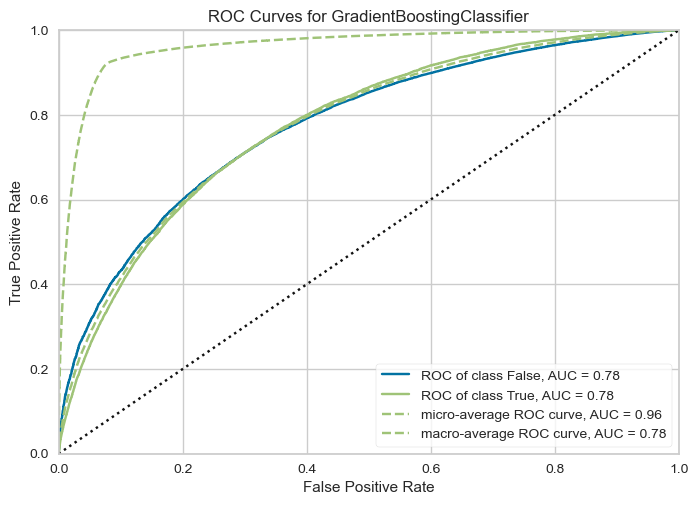

In [45]:
plot_model(tuned_gbc, plot = 'auc')

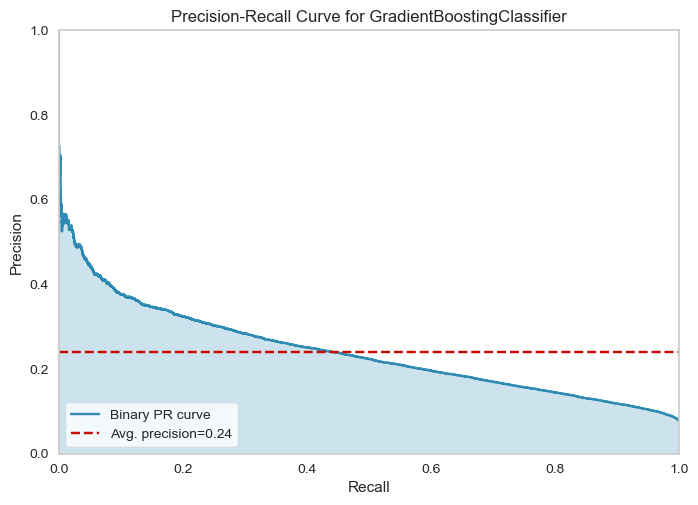

In [46]:
plot_model(tuned_gbc, plot = 'pr')

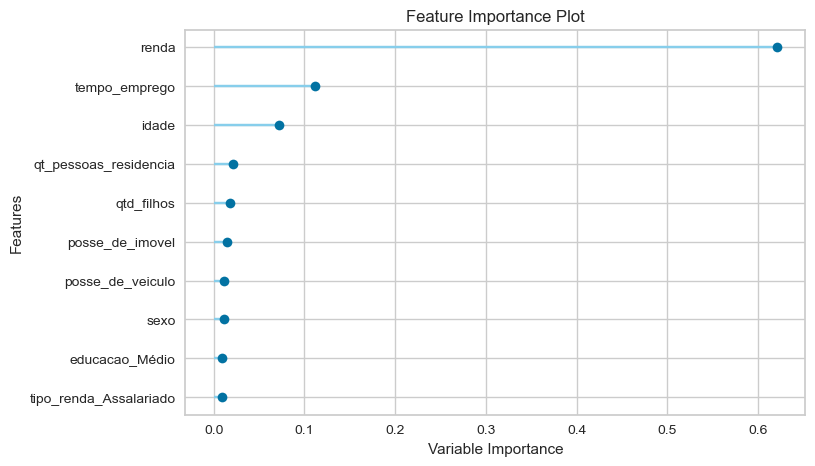

In [47]:
plot_model(tuned_gbc, plot='feature')

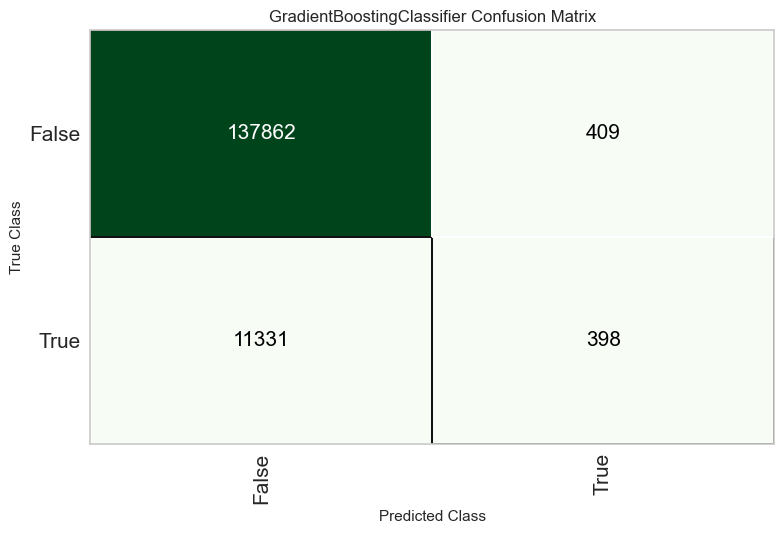

In [48]:
plot_model(tuned_gbc, plot = 'confusion_matrix')

# Predict na amostra de test / hold-out

In [49]:
predict_model(tuned_gbc);


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9217,0.7762,0.0339,0.4932,0.0635,0.0540,0.1137


### Finalizando o modelo para deploy

In [50]:
final_gbc = finalize_model(tuned_gbc)

In [51]:
#Parâmetros finais do modelo Random Forest para deploy
print(final_gbc)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                            criterion='friedman_mse', init=None,
                   

In [52]:
predict_model(final_gbc);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9208,0.7894,0.0773,0.4613,0.1325,0.1125,0.1645


# 13.0 Predizendo o conjunto de dados que não foi usado no treino

In [57]:
# Carregar os dados para previsões
data_unseen = pd.read_feather('credit_scoring.ftr')

# Fazer previsões com o modelo final ajustado
unseen_predictions = predict_model(tuned_gbc, data=data_unseen)

# Exibir as primeiras linhas das previsões
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9230,0.7909,0.0406,0.6149,0.0762,0.0671,0.1440


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873972,1.0,2515.389893,False,0,0.8766
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.189941,False,0,0.8940
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.290039,False,0,0.9350
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.169922,False,0,0.9779
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.080078,False,0,0.8470


### Finalizando o modelo

In [55]:
save_model(final_gbc,'Final GBC Model analises de credito 28Jun2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                             criterion='friedman_mse', init=None,
    

#### Insights Principais

1. **Importância das Variáveis:**
   - A análise de importância de variáveis revelou que características como idade, renda, tempo de emprego e histórico de crédito foram fundamentais na predição de inadimplência.
   - A posse de veículo e imóvel, bem como o estado civil e educação dos clientes, também influenciaram significativamente as previsões.

2. **Perfil de Risco:**
   - Clientes mais jovens com menos tempo de emprego e renda mais baixa tendem a apresentar maior risco de inadimplência.
   - Indivíduos com maior número de filhos ou responsáveis por mais pessoas na residência também mostraram uma tendência maior de dificuldades financeiras.

3. **Otimização de Estratégias de Crédito:**
   - Com base nos modelos desenvolvidos, instituições financeiras podem otimizar suas estratégias de concessão de crédito, segmentando clientes com base no perfil de risco estimado.
   - Isso pode resultar em melhores taxas de aprovação para clientes de baixo risco e redução de perdas associadas à inadimplência.

#### Conclusão

A análise de crédito utilizando modelos de aprendizado de máquina mostrou-se eficaz para prever a probabilidade de inadimplência com base em diversas variáveis. A utilização de Gradient Boosting Classifier como modelo final proporcionou uma boa performance em termos de AUC e outras métricas relevantes. Esses insights não apenas ajudam na tomada de decisões mais informadas para concessão de crédito, mas também contribuem para a gestão de riscos financeiros de forma mais eficiente e precisa.

Essa abordagem demonstra o potencial dos modelos preditivos na transformação digital do setor financeiro, proporcionando insights valiosos que podem ser diretamente aplicados para melhorar a eficiência operacional e a experiência do cliente.

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.

In [ ]:
import streamlit as st
import pandas as pd
import joblib
from pycaret.classification import load_model, predict_model
import matplotlib.pyplot as plt

# Carregar modelo
final_gbc = joblib.load('Final GBC Model analises de credito 28Jun2024.pkl')

# Definir imagem de fundo
page_bg_img = '''
<style>
body {
background-image: url("https://www.nomus.com.br/blog-industrial/wp-content/uploads/2019/07/an%C3%A1lise-de-cr%C3%A9dito.jpg");
background-size: cover;
}
</style>
'''

st.markdown(page_bg_img, unsafe_allow_html=True)

st.title('Análise de Crédito')

# Carregador de arquivo
uploaded_file = st.file_uploader("Carregar arquivo CSV ou FTR", type=['csv', 'ftr'])

if uploaded_file is not None:
    if uploaded_file.name.endswith('csv'):
        data = pd.read_csv(uploaded_file)
    else:
        data = pd.read_feather(uploaded_file)
    
    st.write('Dados carregados com sucesso:')
    st.write(data.head())

    # Prever dados não vistos
    unseen_predictions = predict_model(final_gbc, data=data)
    
    st.write('Previsões:')
    st.write(unseen_predictions.head())

    # Calcular a acurácia comparando 'default' com 'Label'
    from sklearn.metrics import accuracy_score

    # Assegurando que as colunas 'default' e 'Label' existem
    if 'default' in unseen_predictions.columns and 'Label' in unseen_predictions.columns:
        accuracy = accuracy_score(unseen_predictions['default'], unseen_predictions['Label'])
        st.write(f'Acurácia: {accuracy}')
    else:
        st.write('Colunas "default" e/ou "Label" não encontradas nas previsões.')

    # Gráfico das variáveis mais importantes
    st.subheader('Importância das Variáveis')
    feature_importances = final_gbc.named_steps['model'].feature_importances_
    features = data.columns

    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    fig, ax = plt.subplots()
    ax.barh(importance_df['Feature'], importance_df['Importance'])
    ax.set_xlabel('Importância')
    ax.set_title('Importância das Variáveis')
    st.pyplot(fig)
else:
    st.write('Por favor, carregue um arquivo CSV ou FTR.')
